In [3]:
# Import and preprocess data
import pandas as pd

In [18]:
dataset = pd.read_csv('Guns.csv', usecols = ['state', 'year', 'income', 'violent','prisoners'], \
                      index_col = ['state', 'year'])

In [19]:
years = dataset.index.get_level_values('year').to_list()
dataset['year'] = pd.Categorical(years)

In [20]:
dataset['year']

state    year
Alabama  1977    1977
         1978    1978
         1979    1979
         1980    1980
         1981    1981
                 ... 
Wyoming  1995    1995
         1996    1996
         1997    1997
         1998    1998
         1999    1999
Name: year, Length: 1173, dtype: category
Categories (23, int64): [1977, 1978, 1979, 1980, ..., 1996, 1997, 1998, 1999]

In [21]:
from linearmodels import PooledOLS
import statsmodels.api as sm

In [22]:
exog = sm.tools.tools.add_constant(dataset['income'])
endog = dataset['violent']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

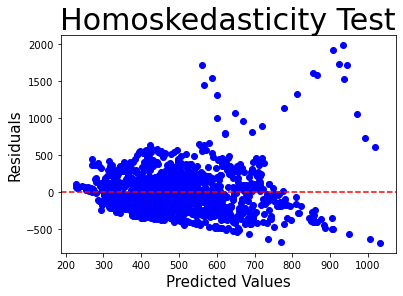

In [23]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [24]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(dataset['income']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))
# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 200.15502156044568, 'LM p-val': 3.442621728588946e-44, 'F-Stat': 120.35903993735407, 'F p-val': 2.925453555717697e-48}
{'LM-Stat': 110.96166044221745, 'LM p-val': 6.032616972194349e-26, 'F-Stat': 122.34596392437228, 'F p-val': 4.048137598792713e-27}


In [25]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

0.08937264851640213


In [34]:
dataset['income']

state    year
Alabama  1977     9563.148
         1978     9932.000
         1979     9877.028
         1980     9541.428
         1981     9548.351
                   ...    
Wyoming  1995    14070.160
         1996    14032.230
         1997    14790.980
         1998    15225.510
         1999    15765.070
Name: income, Length: 1173, dtype: float64

In [32]:
dataset[['income','prisoners']]

income  prisoners
state   year                      
Alabama 1977   9563.148         83
        1978   9932.000         94
        1979   9877.028        144
        1980   9541.428        141
        1981   9548.351        149
...                 ...        ...
Wyoming 1995  14070.160        254
        1996  14032.230        289
        1997  14790.980        310
        1998  15225.510        326
        1999  15765.070        327

[1173 rows x 2 columns]

In [33]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects
exog = sm.tools.tools.add_constant(dataset[['income','prisoners']])
endog = dataset['violent']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
#print results
print(re_res)
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                violent   R-squared:                        0.1830
Estimator:              RandomEffects   R-squared (Between):              0.2730
No. Observations:                1173   R-squared (Within):               0.1678
Date:                Thu, Apr 08 2021   R-squared (Overall):              0.2621
Time:                        15:00:33   Log-likelihood                   -7124.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      131.03
Entities:                          51   P-value                           0.0000
Avg Obs:                       23.000   Distribution:                  F(2,1170)
Min Obs:                       23.000                                           
Max Obs:                       23.000   F-statistic (robust):             131.03
                            

In [27]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 

    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval
hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 9.426371343365807
degrees of freedom: 2
p-Value: 0.008976136961510497
